In [20]:
from equadratures import *
from equadratures.datasets import score
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

%matplotlib notebook

In this notebook we perform a basic grid search to find suitable values for the hyper-parameters: polynomial order $k$ and number of reduced dimensions $m$. We do this for the two design parameters $y_1$ and $y_2$ (see the "obtaining_subspaces" notebook for more info on these).

To account for the randomness involved in obtaining subspaces, for each value of $k$ and $m$ we run five trials, and take the best result. This takes a while, so if you just want to plot the results, set `run=False` to load previously obtained results.

In [25]:
# Run a grid search ourselves?
run = True

# values of m and k to try (overwritten if run=False)
m_list    = [1,2,3,4] # reduced dimensions to try
k_list    = [1,2,2,3]   # poly order

## Perform the grid search

In [26]:
if run:
    X  = np.load('../Data/X.npy')
    y1 = np.load('../Data/y1.npy')
    y2 = np.load('../Data/y2.npy')

    nrow, dim = np.shape(X)

    nm    = len(m_list)
    nk    = len(k_list)

    y1_r2   = np.zeros([nm,nk])
    y2_r2   = np.zeros([nm,nk])  
    
    for im, m in enumerate(m_list):
        print('\t%i: m =  %.1f' %(im, m))

        for ik, k in enumerate(k_list):
            if(k==1 and m>1): # If k==1 and m>1 is desired, use active-subspace
                y1_r2[im,ik] = 0.0
                y2_r2[im,ik] = 0.0
            else:
                print('\t\t%i: k =  %.1f' %(ik+1, k))

                y1temp = 0.0
                y2temp = 0.0
                for r in range(5):
                    # get subspaces
                    mysubspace1 = Subspaces(method='variable-projection',sample_points=X,sample_outputs=y1,
                                            polynomial_degree=k, subspace_dimension=m)
                    mysubspace2 = Subspaces(method='variable-projection',sample_points=X,sample_outputs=y2,
                                            polynomial_degree=k, subspace_dimension=m)

                    W1 = mysubspace1.get_subspace()
                    W2 = mysubspace2.get_subspace()
                    active_subspace1 = W1[:,0:m]
                    active_subspace2 = W2[:,0:m]
                    u1 = X @ active_subspace1
                    u2 = X @ active_subspace2
                    y1test = y1
                    y2test = y2
                    subpoly1 = mysubspace1.get_subspace_polynomial()
                    subpoly2 = mysubspace2.get_subspace_polynomial()

                    # Predict y1 and y2 at test points using subspace poly. Get r2 and RMSE
                    y1pred = subpoly1.get_polyfit(u1)
                    y2pred = subpoly2.get_polyfit(u2)

                    y1temp = score(y1pred,y1test,metric='adjusted_r2',X=X)
                    if(y1temp>=y1_r2[im,ik]): y1_r2[im,ik] = y1temp

                    y2temp = score(y2pred,y2test,metric='adjusted_r2',X=X)
                    if(y2temp>=y2_r2[im,ik]): y2_r2[im,ik] = y2temp

    # Store in dataframe to display results
    col_names = ['Order %d'%k for k in k_list]
    row_names = ['%dD'%m      for m in m_list]
    data1 = pd.DataFrame(y1_r2[:,:],columns=col_names,index=row_names)
    data2 = pd.DataFrame(y2_r2[:,:],columns=col_names,index=row_names)
    print('*** Yp ***')
    display(data1)
    print('*** Rr ***')
    display(data2)

    # Save results to file
    np.save('Yp_results.npy',y1_r2)
    np.save('Rr_results.npy',y2_r2)

	0: m =  1.0
		1: k =  1.0
		2: k =  2.0
		3: k =  2.0
		4: k =  3.0
	1: m =  2.0
		2: k =  2.0
		3: k =  2.0
		4: k =  3.0
	2: m =  3.0
		2: k =  2.0
		3: k =  2.0
		4: k =  3.0
	3: m =  4.0
		2: k =  2.0
		3: k =  2.0
		4: k =  3.0
*** Yp ***


,Order 1,Order 2,Order 2,Order 3
1D,0.991171,0.991374,0.991374,0.991304
2D,0.000000,0.994651,0.994651,0.994936
3D,0.000000,0.997252,0.997244,0.997595
4D,0.000000,0.997579,0.997581,0.998603


*** Rr ***


,Order 1,Order 2,Order 2,Order 3
1D,0.320045,0.710109,0.710109,0.802618
2D,0.000000,0.870906,0.873149,0.937535
3D,0.000000,0.888980,0.889039,0.968293
4D,0.000000,0.897420,0.897811,0.982354


## Plot the results


<IPython.core.display.Javascript object>


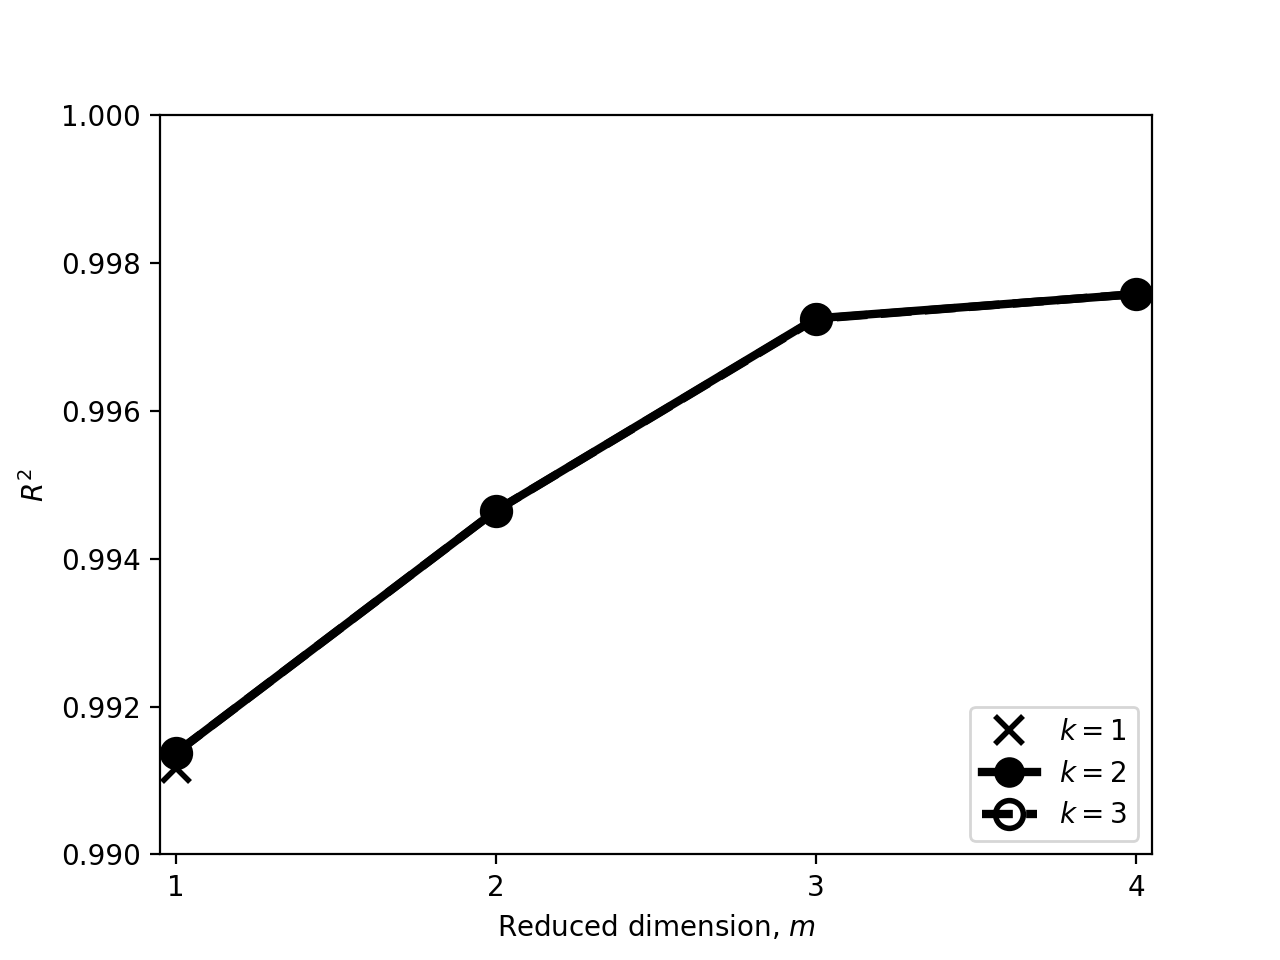

<IPython.core.display.Javascript object>


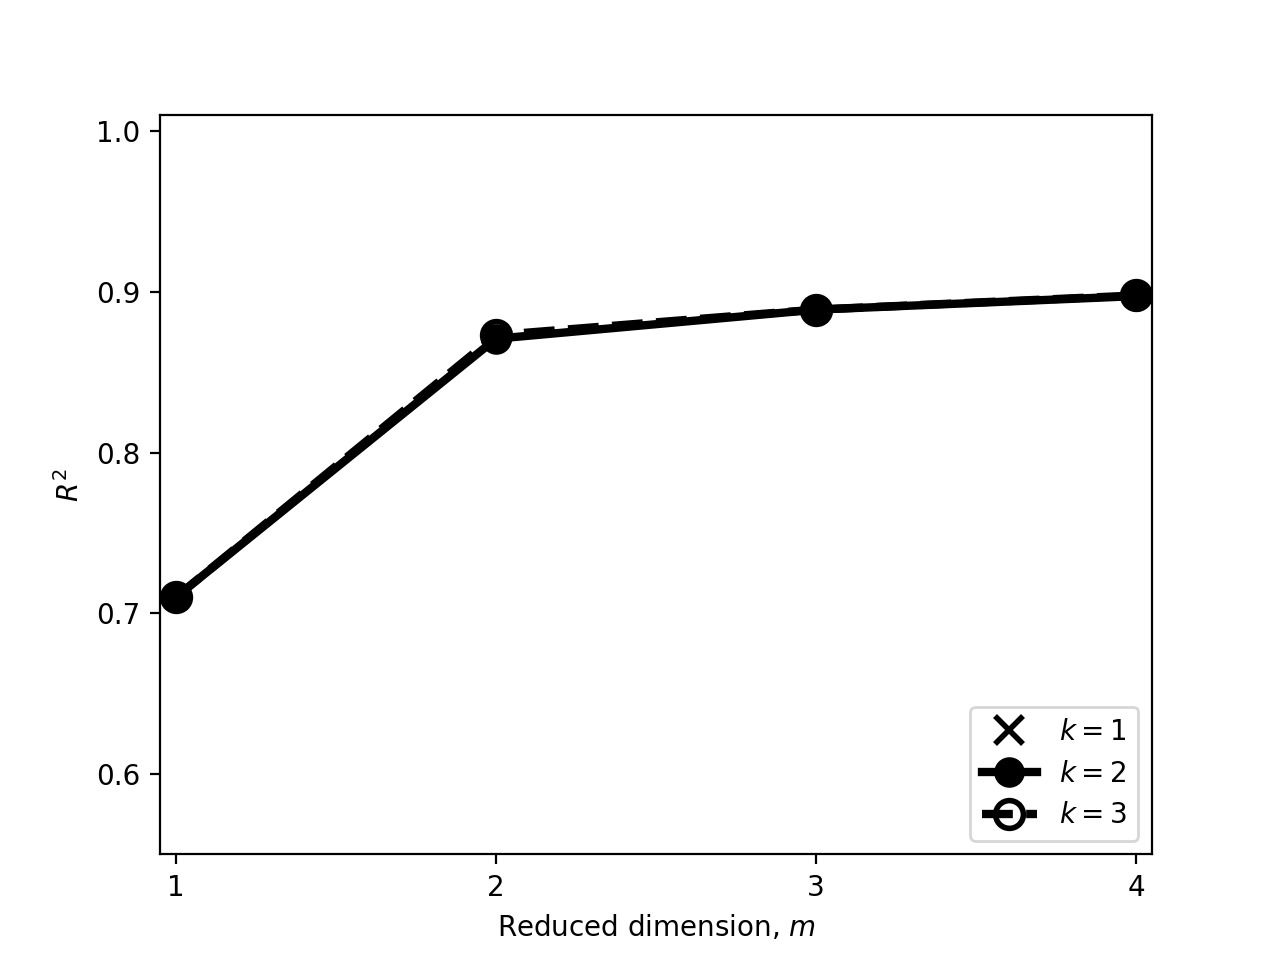

In [29]:
y1_r2 = np.load('Yp_results.npy')
y2_r2 = np.load('Rr_results.npy')

fig1, ax1 = plt.subplots()
ax1.plot(m_list[0],y1_r2[0,0],'kx',label='$k = 1$',ms=10,mew=2)
ax1.plot(m_list,y1_r2[:,1],'ko-',label='$k = 2$',ms=10,lw=3)                                                                                                                                            
ax1.plot(m_list,y1_r2[:,2],'ko--',label='$k = 3$',mfc='none',mew=2,ms=10,lw=3)
ax1.set_xlim([0.95,4.05])
ax1.set_ylim([0.99,1.0])
ax1.set_xticks([1,2,3,4])
ax1.set_xlabel('Reduced dimension, $m$')
ax1.set_ylabel('$R^2$')
ax1.legend(loc='lower right')
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(m_list[0],y2_r2[0,0],'kx',label='$k = 1$',ms=10,mew=2)
ax2.plot(m_list,y2_r2[:,1],'ko-',label='$k = 2$',ms=10,lw=3)                                                                                                                                            
ax2.plot(m_list,y2_r2[:,2],'ko--',label='$k = 3$',mfc='none',mew=2,ms=10,lw=3)
ax2.set_xlim([0.95,4.05])
ax2.set_ylim([0.55,1.01])
ax2.set_xticks([1,2,3,4])
ax2.set_xlabel('Reduced dimension, $m$')
ax2.set_ylabel('$R^2$')
ax2.legend(loc='lower right')

plt.show()

## Conclusions
* $k=1$ and $m=1$ are acceptable for the $O_{Yp}$ subspace. Increasing $k$ and/or $m$ offers slight increases in accuracy, but at the expensive of descreased interpretability. 

* $m\ge2$ is required for acceptable accuracy for the $O_{Rr}$ objective. Increasing $k$ from $2$ to $3$ offers a further increase in accuracy.

**Note**: We have only looked at the *training errors* here. If one were to explore higher orders than $k=3$, it would be advisable to split the data into train/test sets and examine the *test errors*. A KFold cross validation could even be performed.